In [1]:
import numpy as np
import sys,os
import random
import pygame
import pygame.surfarray as surfarray
from pygame.locals import *
from itertools import cycle

In [2]:
#!/usr/bin/env python
from __future__ import print_function

import argparse
import skimage as skimage
from skimage import transform, color, exposure, io
from skimage.transform import rotate
from skimage.viewer import ImageViewer
import random
import numpy as np
from collections import deque
import json
from zoo.pipeline.api.net import Net
from zoo.pipeline.api.keras.models import Sequential
from zoo.pipeline.api.keras.layers.core import Dense, Dropout, Activation,Flatten
from zoo.pipeline.api.keras.layers.convolutional import Convolution2D
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plot
import matplotlib.image as image
from zoo.pipeline.api.net import Net
from os import listdir
from os.path import isfile, join, getmtime
import imageio
work_space = os.getcwd()
sys.path.append(work_space+"/game/")
import wrapped_flappy_bird as game
from bigdl.nn.layer import Model

/usr/local/lib/python2.7/dist-packages/skimage/viewer/utils/core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "


In [3]:
GAME = 'bird' # the name of the game being played for log files
CONFIG = 'nothreshold'
ACTIONS = 2 # number of valid actions
GAMMA = 0.99 # decay rate of past observations
OBSERVATION = 32. # timesteps to observe before training
EXPLORE = 3000000. # frames over which to anneal epsilon
FINAL_EPSILON = 0.0001 # final value of epsilon
INITIAL_EPSILON = 0.1 # starting value of epsilon
REPLAY_MEMORY = 50000 # number of previous transitions to remember
BATCH = 32 # size of minibatch
FRAME_PER_ACTION = 1
LEARNING_RATE = 1e-4
img_rows , img_cols = 80, 80
#Convert image into Black and white
img_channels = 4 #We stack 4 frames
BASE_PATH = os.getcwd()
SAVE_GIF = 200 # timesteps to save the gif
step_record = list()

In [4]:
def buildmodel():
    print("Now we build the model")
    model = Sequential()
    model.add(Convolution2D(32, 8, 8, subsample=(4, 4), border_mode='same',
                            input_shape=(img_rows, img_cols, img_channels)))  # 80*80*4
    model.add(Activation('relu'))
    model.add(Convolution2D(64, 4, 4, subsample=(2, 2), border_mode='same'))
    model.add(Activation('relu'))
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode='same'))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(2))
    print("We finish building the model")
    return model



In [5]:
def playGame(model , is_train = True):

    living_step = 0
    # open up a game state to communicate with emulator
    game_state = game.GameState()

    # store the previous observations in replay memory
    D = deque()

    # get the first state by doing nothing and preprocess the image to 80x80x4
    do_nothing = np.zeros(ACTIONS)
    do_nothing[0] = 1
    x_t, r_0, terminal = game_state.frame_step(do_nothing)

    x_t = skimage.color.rgb2gray(x_t)
    x_t = skimage.transform.resize(x_t, (80, 80))
    x_t = skimage.exposure.rescale_intensity(x_t, out_range=(0, 255))

    x_t = x_t / 255.0

    s_t = np.stack((x_t, x_t, x_t, x_t), axis=2)
    # print (s_t.shape)

    # In Keras, need to reshape
    s_t = s_t.reshape(1, s_t.shape[0], s_t.shape[1], s_t.shape[2])  # 1*80*80*4
    
    if is_train:   
        OBSERVE = OBSERVATION
        epsilon = INITIAL_EPSILON
    else:
        OBSERVE = 999999999  # We keep observe, never train
        epsilon = FINAL_EPSILON
    # how many step to execute
    execute_step = 0
    if is_train:
        execute_step = 3000000
    else:
        execute_step = 1000
        
        
    gifSaveCount = 0
    saveImage = False
    t = 0
    while (t<execute_step): 
        loss = 0
        Q_sa = 0
        action_index = 0
        r_t = 0
        a_t = np.zeros([ACTIONS])
        # choose an action epsilon greedy
        if t % FRAME_PER_ACTION == 0:
            if random.random() <= epsilon:
                print("----------Random Action----------")
                action_index = random.randrange(ACTIONS)
                a_t[action_index] = 1
            else:
                q = model.predict(s_t)# input a stack of 4 images, get the prediction
                max_Q = np.argmax(q)
                action_index = max_Q
                a_t[max_Q] = 1
        # We reduced the epsilon gradually
        if epsilon > FINAL_EPSILON and t > OBSERVE:
            epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE

        # run the selected action and observed next state and reward
        x_t1_colored, r_t, terminal = game_state.frame_step(a_t)

        x_t1 = skimage.color.rgb2gray(x_t1_colored)
        x_t1 = skimage.transform.resize(x_t1, (80, 80))
        x_t1 = skimage.exposure.rescale_intensity(x_t1, out_range=(0, 255))
        
        if t % SAVE_GIF == 0:
            saveImage = True
            if os.path.exists('./img'):
                for filename in os.listdir('./img'):
                    file_path = os.path.join(os.getcwd(),filename)
                    if os.path.isfile(file_path):
                        os.remove(file_path)
            else:
                os.mkdir('./img')



        if saveImage:
            rotate_x_t1_image = transform.rotate(x_t1_colored,270,resize=True)
            io.imsave('img/image'+str(gifSaveCount)+'.png',rotate_x_t1_image)
            gifSaveCount+=1
            if gifSaveCount > 100:
                saveToGif()
                gifSaveCount = 0
                saveImage = False
               
                    
        x_t1 = x_t1 / 255.0

        x_t1 = x_t1.reshape(1, x_t1.shape[0], x_t1.shape[1], 1)  # 1x80x80x1
        s_t1 = np.append(x_t1, s_t[:, :, :, :3], axis=3)

        # store the transition in D
        D.append((s_t, action_index, r_t, s_t1, terminal))
        if len(D) > REPLAY_MEMORY:
            D.popleft()

        # only train if done observing
        if t > OBSERVE:
            # sample a minibatch to train on
            minibatch = random.sample(D, BATCH)
            model,loss = training(minibatch)

        s_t = s_t1
        t = t + 1
        if terminal:
            step_record.append(living_step)
            living_step = 0
        else:
            living_step += 1
        # save progress every 10000 iterations
        if t % 10000 == 0 and is_train:
            print("Now we save model")
            model.saveModel("/model/model"+str(t)+".bigdl","/model/model"+str(t)+".bin",True)

        # print info
        state = ""
        if t <= OBSERVE:
            state = "observe"
        elif t > OBSERVE and t <= OBSERVE + EXPLORE:
            state = "explore"
        else:
            state = "train"
        print ("Living steps : ",living_step)
        print("TIMESTEP", t, "/ STATE", state, \
              "/ EPSILON", epsilon, "/ ACTION", action_index, "/ REWARD", r_t,
              "/ Loss ", loss)

    print("Episode finished!")
    print("************************")
                

In [6]:
# loas a pretrained bigdl model# loas a  
def loadPretrainedBigdlModel(model_path, weight_path):
    print("Now we load weight")
    if model_path == None or not os.path.exists(model_path):
        print ("Not a valid model_path, training from scratch")
        raise Exception("not a valid model_path")
    else:
        if weight_path == None or not os.path.exists(weight_path):
            model =Sequential()
            print ("not a valid weight_path, using initialized weight")
            model=Net.load(model_path=model_path)
        else:
            # load_mode
            model=Net.load(model_path=model_path,weight_path=weight_path)
            print("Weights load successfully")
        playGame(model,False)      

In [7]:
# loas a pretrained keras model
def loadPretrainedKerasModel(model_path):
    if model_path == None or not os.path.exists(model_path):
        raise Exception("not a valid model_path")
    else:
        model = Model.load_keras(json_path=None, hdf5_path="./model/model100000.h5")
        print("Weight load successfully")
        playGame(model,False)   

In [8]:
# training model from scratch# trainin 
def trainModel():
    model = buildMode()
    model.compile(loss='mse', optimizer='adam')
    playGame(model)

In [9]:
def saveToGif():
    mypath = os.getcwd() + '/img'
    filenames = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    path_dict = {}
    for i in range(len(filenames)):
        path_dict[filenames[i]] = getmtime(join(mypath, filenames[i]))
    sorted_filenames = sorted(path_dict.items(), key=lambda x: x[1], reverse=False)
    with imageio.get_writer('./movie.gif', mode='I', fps=10) as writer:
        for filename in sorted_filenames:
            image = imageio.imread('./img/' + filename[0])
            writer.append_data(image)

In [10]:
def training(minibatch):
    # Now we do the experience replay
    state_t, action_t, reward_t, state_t1, terminal = zip(*minibatch)
    state_t = np.concatenate(state_t)
    state_t1 = np.concatenate(state_t1)
    targets = np.zeros((BATCH,ACTIONS))
    Q_sa = model.predict(state_t1)
    result_qsa=Q_sa.map(lambda elem:max(elem)).collect()
    for i in range(BATCH):
        targets[i][action_t[i]] = reward_t[i] + GAMMA *result_qsa[i] * np.invert(terminal[i])
    model.fit(state_t,targets)
    loss = getLoss(model,state_t,targets)
    return model,loss

In [11]:
def getLoss(model,state,targets):
    # get the predict result in RDD type
    predict_state = model.predict(state)
    item_list = predict_state.collect()
    loss = 0
    i = 0
    for predict_actions in item_list:
        loss += 0.5 * np.square(np.abs(targets[i][0]-predict_actions[0])+np.abs(targets[i][1]-predict_actions[1]))
        i+=1
    predict_state = None
    print ("**************************************LOSS***********************************: %s"%(loss/BATCH))
    return loss/BATCH

In [14]:
# now we load a pretrained bigdl model
# model_path = "./model/model31500.bigdl"
# weight_path = "./model/model31500.bin"
# loadPretrainedBigdlModel(model_path,weight_path)

model_path = "./model/model100000.h5"
loadPretrainedKerasModel(model_path=model_path)

creating: createSequential
creating: createSpatialConvolution
creating: createXavier
creating: createZeros
creating: createReLU
creating: createSpatialConvolution
creating: createXavier
creating: createZeros
creating: createReLU
creating: createSpatialConvolution
creating: createXavier
creating: createZeros
creating: createReLU
creating: createReshape
creating: createLinear
creating: createXavier
creating: createZeros
creating: createReLU
creating: createLinear
creating: createXavier
creating: createZeros
Weight load successfully
Living steps :  1
TIMESTEP 1 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  2
TIMESTEP 2 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  3
TIMESTEP 3 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  4
TIMESTEP 4 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  5
TIMESTEP 5 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWAR

Living steps :  80
TIMESTEP 80 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  81
TIMESTEP 81 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  82
TIMESTEP 82 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  83
TIMESTEP 83 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  84
TIMESTEP 84 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  85
TIMESTEP 85 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  86
TIMESTEP 86 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  87
TIMESTEP 87 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  88
TIMESTEP 88 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  89
TIMESTEP 89 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  90
T

Living steps :  163
TIMESTEP 163 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  164
TIMESTEP 164 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  165
TIMESTEP 165 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  166
TIMESTEP 166 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  167
TIMESTEP 167 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  168
TIMESTEP 168 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  169
TIMESTEP 169 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  170
TIMESTEP 170 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 1 / Loss  0
Living steps :  171
TIMESTEP 171 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  172
TIMESTEP 172 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Li

Living steps :  247
TIMESTEP 247 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  248
TIMESTEP 248 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  249
TIMESTEP 249 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  250
TIMESTEP 250 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  251
TIMESTEP 251 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  252
TIMESTEP 252 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  253
TIMESTEP 253 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  254
TIMESTEP 254 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  255
TIMESTEP 255 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  256
TIMESTEP 256 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0


Living steps :  329
TIMESTEP 329 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  330
TIMESTEP 330 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  331
TIMESTEP 331 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  332
TIMESTEP 332 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  333
TIMESTEP 333 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  334
TIMESTEP 334 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  335
TIMESTEP 335 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  336
TIMESTEP 336 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  337
TIMESTEP 337 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  338
TIMESTEP 338 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0


Living steps :  413
TIMESTEP 413 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  414
TIMESTEP 414 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  415
TIMESTEP 415 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  416
TIMESTEP 416 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  417
TIMESTEP 417 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  418
TIMESTEP 418 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  419
TIMESTEP 419 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  420
TIMESTEP 420 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  421
TIMESTEP 421 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  422
TIMESTEP 422 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0


Living steps :  498
TIMESTEP 498 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  499
TIMESTEP 499 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  500
TIMESTEP 500 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  501
TIMESTEP 501 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  502
TIMESTEP 502 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  503
TIMESTEP 503 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  504
TIMESTEP 504 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 1 / Loss  0
Living steps :  505
TIMESTEP 505 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  506
TIMESTEP 506 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  507
TIMESTEP 507 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Li

Living steps :  585
TIMESTEP 585 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  586
TIMESTEP 586 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  587
TIMESTEP 587 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  588
TIMESTEP 588 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  589
TIMESTEP 589 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  590
TIMESTEP 590 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  591
TIMESTEP 591 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  592
TIMESTEP 592 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  593
TIMESTEP 593 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Loss  0
Living steps :  594
TIMESTEP 594 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0


Living steps :  667
TIMESTEP 667 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Loss  0
Living steps :  668
TIMESTEP 668 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  669
TIMESTEP 669 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  670
TIMESTEP 670 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  671
TIMESTEP 671 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  672
TIMESTEP 672 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  673
TIMESTEP 673 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  674
TIMESTEP 674 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
----------Random Action----------
Living steps :  675
TIMESTEP 675 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  676
TIMESTEP 676 / STATE observe / EPSILON 0.0001 

Living steps :  69
TIMESTEP 750 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  70
TIMESTEP 751 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  71
TIMESTEP 752 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  72
TIMESTEP 753 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  73
TIMESTEP 754 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  74
TIMESTEP 755 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  75
TIMESTEP 756 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  76
TIMESTEP 757 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  77
TIMESTEP 758 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  78
TIMESTEP 759 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living ste

Living steps :  63
TIMESTEP 833 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  64
TIMESTEP 834 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  65
TIMESTEP 835 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  66
TIMESTEP 836 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  67
TIMESTEP 837 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  68
TIMESTEP 838 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  69
TIMESTEP 839 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  70
TIMESTEP 840 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  71
TIMESTEP 841 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  72
TIMESTEP 842 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living ste

Living steps :  152
TIMESTEP 922 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  153
TIMESTEP 923 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  154
TIMESTEP 924 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  155
TIMESTEP 925 / STATE observe / EPSILON 0.0001 / ACTION 1 / REWARD 0.1 / Loss  0
Living steps :  156
TIMESTEP 926 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  157
TIMESTEP 927 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  158
TIMESTEP 928 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  159
TIMESTEP 929 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  160
TIMESTEP 930 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0
Living steps :  161
TIMESTEP 931 / STATE observe / EPSILON 0.0001 / ACTION 0 / REWARD 0.1 / Loss  0


In [17]:
print("now we print the generated gif image")
from IPython.display import Image
Image(url='./movie.gif')

now we print the generated gif image


now we print the living steps


Text(0,0.5,'living steps')

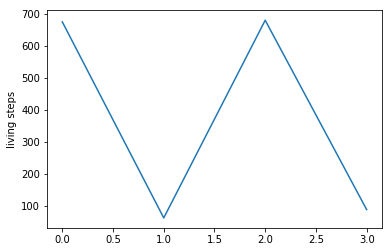

In [18]:
print("now we print the living steps")
y_value = [step for step in step_record]
plot.plot(y_value)
plot.ylabel("living steps")